In [1]:
# Load and preprocess images

In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [6]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


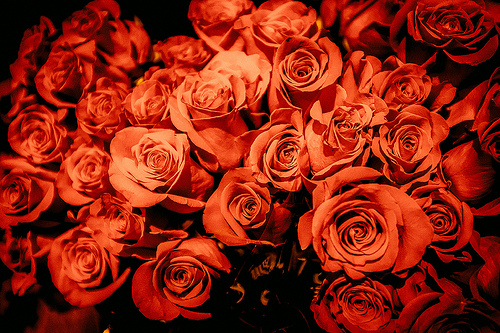

In [11]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[2]))

In [12]:
# Load data using a keras utility
batch_size = 32
img_height = 180
img_width = 180

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset='training',
    seed=123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [17]:
# Visualize the data

In [18]:
import matplotlib.pyplot as plt

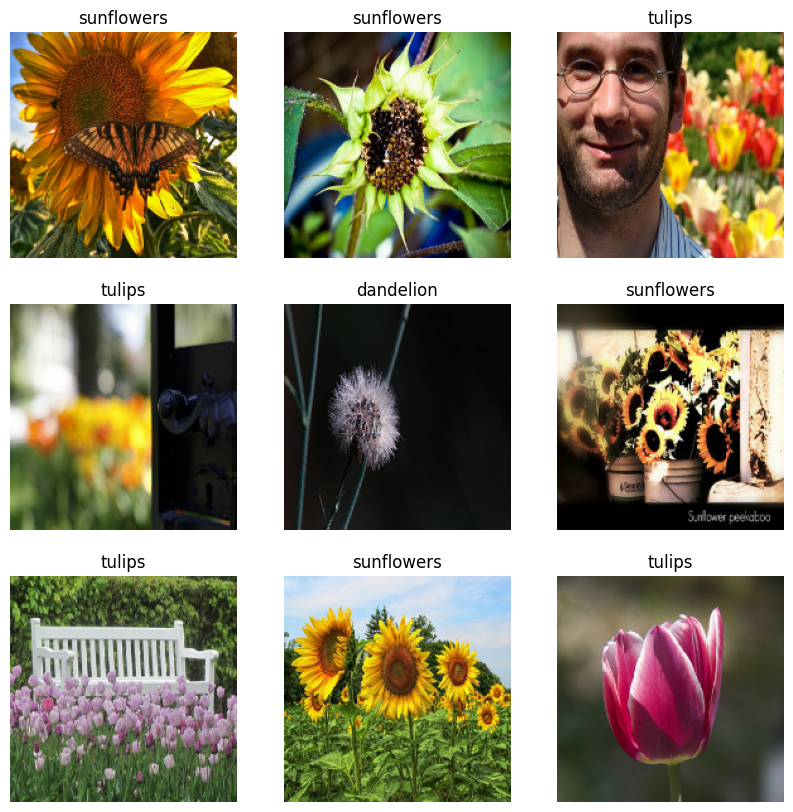

In [20]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [22]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [23]:
# Standardize the data
normalization_layer=tf.keras.layers.Rescaling(1./255)

In [24]:
normalized_ds = train_ds.map(lambda x, y:(normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [25]:
# Configure the dataset for performance

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
# Train a model

In [30]:
num_classes = 5

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [33]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3


92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 452ms/step - accuracy: 0.3584 - loss: 1.4326 - val_accuracy: 0.5450 - val_loss: 1.1221
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 406ms/step - accuracy: 0.6132 - loss: 1.0023 - val_accuracy: 0.6240 - val_loss: 0.9763
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 29s 312ms/step - accuracy: 0.6858 - loss: 0.8457 - val_accuracy: 0.6417 - val_loss: 0.9052


In [ ]:
# Using tf.data for finer control

In [34]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [35]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\91798\\.keras\\datasets\\flower_photos\\sunflowers\\4933229479_c1708bd503.jpg'
b'C:\\Users\\91798\\.keras\\datasets\\flower_photos\\sunflowers\\9555827829_74e6f60f1d_m.jpg'
b'C:\\Users\\91798\\.keras\\datasets\\flower_photos\\dandelion\\18995294384_77543e96b6_n.jpg'
b'C:\\Users\\91798\\.keras\\datasets\\flower_photos\\roses\\16525204061_9b47be3726_m.jpg'
b'C:\\Users\\91798\\.keras\\datasets\\flower_photos\\tulips\\6799076717_575944af91_m.jpg'


In [36]:
# The tree structure of files can be used to compile class_names list

In [37]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name!='LICENSE.txt']))

In [38]:
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [39]:
# Split the dataset into training and validation set

In [40]:
val_size = int(image_count*0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [41]:
# print the length of each dataset
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [42]:
# write a function that converts a file path to an (img, label) pair

In [43]:
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer ecode the label
    return tf.argmax(one_hot)

In [44]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [45]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [46]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [48]:
for image, label in train_ds.take(1):
    print('Image Shape: ', image.numpy().shape)
    print('Label: ', label.numpy())

Image Shape:  (180, 180, 3)
Label:  4


In [49]:
# Configure dataset for performance
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


In [50]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [51]:
# Visualize the data

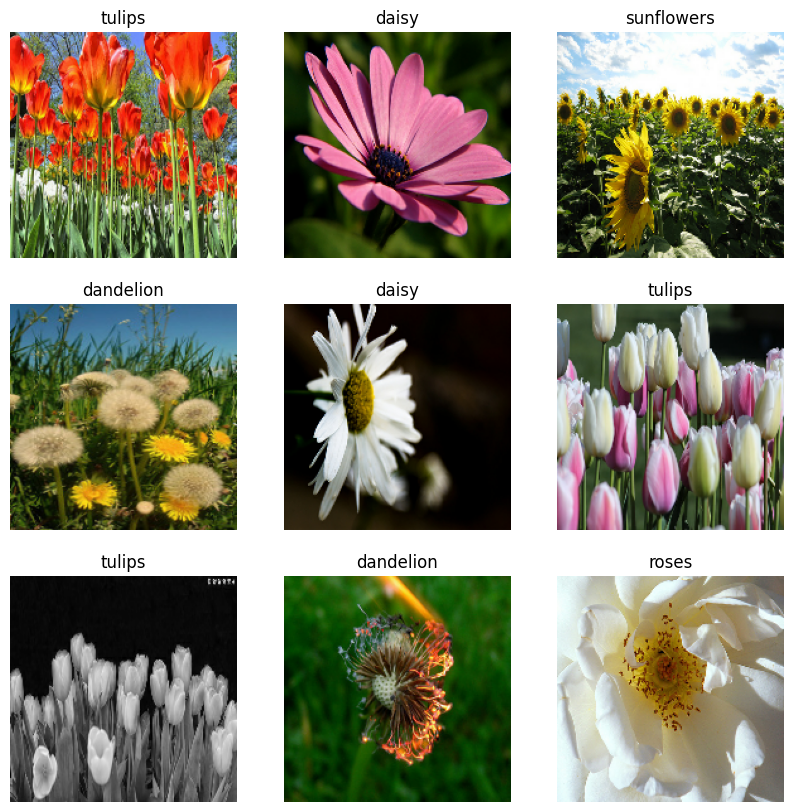

In [52]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis('off')

In [53]:
# Continue training the model

In [56]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 44s 424ms/step - accuracy: 0.7410 - loss: 0.7004 - val_accuracy: 0.7425 - val_loss: 0.6918
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 37s 393ms/step - accuracy: 0.7992 - loss: 0.5228 - val_accuracy: 0.7425 - val_loss: 0.7238
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 309ms/step - accuracy: 0.8848 - loss: 0.3334 - val_accuracy: 0.7561 - val_loss: 0.7925


In [57]:
# Using tensorflow datasets

In [58]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

c:\ProgramData\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...:   0%|          | 0/1 [00:15<?, ? url/s]

In [ ]:
# The flower dataset h